# Video games sales   

We work for the online store Ice, which sells video games all over the world. User and expert reviews, genres, platforms (e.g. Xbox or PlayStation), and historical data on game sales are available from open sources. We need to identify patterns that determine success in sales, in order to identify potential big winners. This will allow the team to spot potential big winners and plan advertising campaigns.
In front of us is data going back to 2016, to support planning for 2017.
Data for 2016 may be incomplete.

Project goal:

**To identify patterns that determine success in sales, in order to identify potential big winners and plan accordingly** 

## Initialization and loading data 

In [37]:
# Loading all the libraries
from scipy import stats as st
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import warnings
warnings.filterwarnings("ignore")
# pd.options.display.float_format = '{:.3f}'.format
import seaborn as sns 

In [38]:
# Load the data file into a DataFrames
games = pd.read_csv('/datasets/games.csv')

## Preparing data 

In [39]:
# view a sample of the data:
games.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [40]:
# general onfo of the data:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [41]:
# checking for explicit duplicates: 
games.duplicated().sum()

0

In [42]:
# checking total share of values missing:
games.isnull().sum()/ games.shape[0] * 100

Name                0.011965
Platform            0.000000
Year_of_Release     1.609333
Genre               0.011965
NA_sales            0.000000
EU_sales            0.000000
JP_sales            0.000000
Other_sales         0.000000
Critic_Score       51.319174
User_Score         40.089740
Rating             40.478612
dtype: float64

We have in total 11 columns and 16715 entries: totally full for Platform and all 4 sales columns (regions), 2 missing values for Name and Genre, and missing more values in other columns (especially reviews - more than half missing, and ESRB rating - 40% missing). Column names include upper case, and two columns (year_of_release and user_score ) need to change data type (into datetime and float). No explicit duplicates. 


### Replacing column names 

In [43]:
# replacing column names into lowercase:
games.columns = games.columns.str.lower()
games.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

### Converting data types

While trying to covert 'user_score' into 'float' - we found that some of it's values are 'tbd' (to be decided). This prevented converting into float, and probably caused the column to be 'object' type. Let's check how many of these 'tbd' are there, and if there are other problematic values in this column: 

In [44]:
games['user_score'].value_counts()

tbd    2424
7.8     324
8       290
8.2     282
8.3     254
       ... 
0.7       2
0.6       2
1.5       2
0         1
9.7       1
Name: user_score, Length: 96, dtype: int64

2424 'tbd' values in user_score. No other problematic values. We will turn them into NaN, which will allow converting the column into 'float' and make calculations. 

In [45]:
# turning 'tbd' values into 'NaN:
games['user_score'].replace({'tbd': np.nan}, inplace=True)
games['user_score'].value_counts()

7.8    324
8      290
8.2    282
8.3    254
8.5    253
      ... 
0.7      2
0.6      2
1.5      2
0        1
9.7      1
Name: user_score, Length: 95, dtype: int64

Now we are ready to change the data types: 

In [46]:
# change the data type of 'year_of_release' into 'datetime', and of 'user_score' into 'float':
games['year_of_release'] = pd.to_datetime(games['year_of_release'], format='%Y')
games['user_score'] = games['user_score'].astype('float')
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16715 non-null object
year_of_release    16446 non-null datetime64[ns]
genre              16713 non-null object
na_sales           16715 non-null float64
eu_sales           16715 non-null float64
jp_sales           16715 non-null float64
other_sales        16715 non-null float64
critic_score       8137 non-null float64
user_score         7590 non-null float64
rating             9949 non-null object
dtypes: datetime64[ns](1), float64(6), object(4)
memory usage: 1.4+ MB


### Missing values 

In [47]:
# number of missing values in each column: 
games.isnull().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         9125
rating             6766
dtype: int64

We have missing values in 5 columns, first we will check the 2 games with no name (and no genre, if they are the same 2): 

In [48]:
# checking the 2 games with missing name: 
games[games['name'].isnull() == True]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993-01-01,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993-01-01,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Yes, it's the same two games without a name or a genre. They are both from 1993, which is quite a long time ago, so we feel safe to drop them from our data.

In [49]:
# drop the 2 rows with no name and genre, and checking we are down to 16713 entries: 
games = games[games['name'].isnull() == False]
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16713 non-null object
year_of_release    16444 non-null datetime64[ns]
genre              16713 non-null object
na_sales           16713 non-null float64
eu_sales           16713 non-null float64
jp_sales           16713 non-null float64
other_sales        16713 non-null float64
critic_score       8137 non-null float64
user_score         7590 non-null float64
rating             9949 non-null object
dtypes: datetime64[ns](1), float64(6), object(4)
memory usage: 1.5+ MB


For the other columns with missing values:
These rows do contain data that might be usefull - so we don't drop them here, but we will pay close attention in the analysis to their implications. See below. 

###  Calculating total sales 

In [50]:
# adding a column with total sales:
games['total_sales'] = games[['na_sales','eu_sales','jp_sales','other_sales']].sum(axis=1)
games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006-01-01,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985-01-01,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008-01-01,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009-01-01,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996-01-01,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38


Now we have the global sales of each game in a dedicated column

## Analysis of data

### Amount of games released every year 

As mentioned above - we will use here (and later whenever needed) only the data of games that do include the year. 

In [51]:
# how many games were released in different years:
games_with_year = games[games['year_of_release'].isnull() == False]
games_with_year['year_of_release'] = games_with_year['year_of_release'].dt.year
games_per_year = games_with_year.pivot_table(index='year_of_release', values='name', aggfunc='count')
games_per_year

,name
year_of_release,
1980,9
1981,46
1982,36
1983,17
1984,14
1985,14
1986,21
1987,16
1988,15


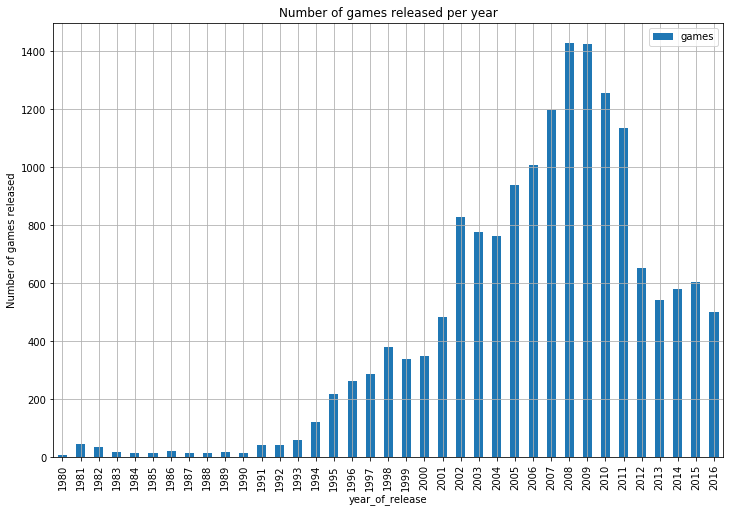

In [52]:
# a graph:
games_per_year.plot(kind='bar', grid=True, figsize=(12, 8))
plt.title('Number of games released per year')
plt.ylabel('Number of games released')
plt.legend(['games'])
plt.show;

We see a very dynamic picture: the 80' are almost all below 22 games released each year (with two local peaks that dont continue, in '81-'82). The 90' have a gradual rise, with a peak of 379 in '98 and solid ~350 at the end of the dacade. The 2000' first dacade had a gradual steep jump to a peak of 1400+ in 2008-2009. Then comes a steep decline to 653 games released in 2012, and since numbers remain in the ~550-650 area (the 502 games in 2016 may be incomplete data)  

### Total sales along the years 

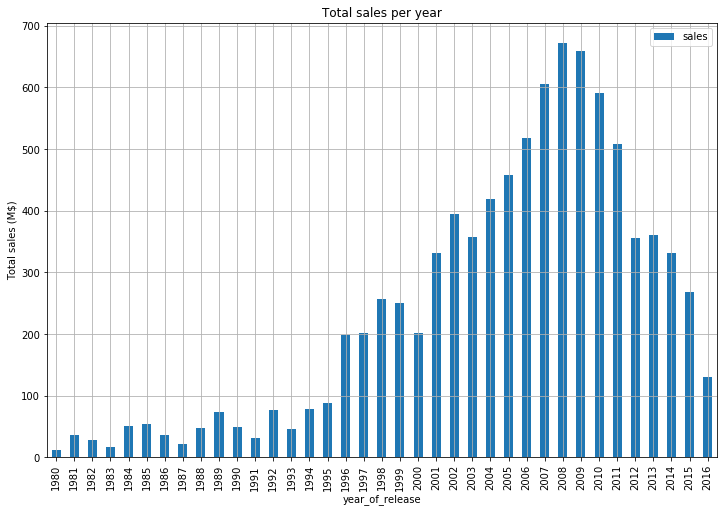

In [53]:
games_with_year.pivot_table(index='year_of_release', values='total_sales', aggfunc='sum').plot(
    kind='bar', grid=True, figsize=(12, 8))
plt.title('Total sales per year')
plt.ylabel('Total sales (M$)')
plt.legend(['sales'])
plt.show;

Global sales in milion USD show generally a similar dynamic to the one that was obderved in the number of games released each year. Dramatic peak in 2008-2009 (above 650M USD a year), then steep decline to 2012 (~350M USD), another decline 2013-2015 (2015 - ~270M USD), and 2016 may be misleading because of incomplete data. For 2016 situation - the trend seems to be less sales every year.   

### Winning platforms & platform sales dynamics 

First let's look at total sales per platform for the whole period:

In [54]:
# total sales per platform:
platform_sales = games.pivot_table(index='platform', values='total_sales',
                                   aggfunc='sum').sort_values(by='total_sales', ascending=False).reset_index()
platform_sales

,platform,total_sales
0,PS2,1255.77
1,X360,971.42
2,PS3,939.65
3,Wii,907.51
4,DS,806.12
5,PS,730.86
6,GBA,317.85
7,PS4,314.14
8,PSP,294.05
9,PC,259.52


For the whole period - 6 platforms have much higher total sales (730-1255 M USD each), while all the rest have less than 320 M USD. 

But does these platforms popularity remain the same along time ? 
Let's check for the top 6 here how high were their sales for each year:

In [55]:
# sales per year_of_release of the 6 best-selling platforms (above 700M$ sales)
win_platforms = ['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS']
games_win_platforms = games_with_year.query('platform in @win_platforms')
sales_by_rel_year = games_win_platforms.pivot_table(index='platform', columns='year_of_release',
                                                    values='total_sales', aggfunc='sum')
sales_by_rel_year

year_of_release,1985,1994,1995,1996,1997,1998,1999,2000,2001,2002,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
platform,,,,,,,,,,,,,,,,,,,,,
DS,0.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,146.94,145.31,119.54,85.02,26.18,11.01,1.54,NaN,NaN,NaN
PS,NaN,6.03,35.96,94.7,136.17,169.49,144.53,96.37,35.59,6.67,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PS2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.17,166.43,205.38,...,75.99,53.90,26.40,5.64,0.45,NaN,NaN,NaN,NaN,NaN
PS3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,73.19,118.52,130.93,142.17,156.78,107.36,113.25,47.76,16.82,3.60
Wii,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,152.77,171.32,206.97,127.95,59.65,21.71,8.59,3.75,1.14,0.18
X360,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,95.41,135.26,120.29,170.03,143.84,99.74,88.58,34.74,11.96,1.52


Again we see very dynamic data: 

Some platforms used to be very popular but now have zero sales (e.g. DS, PS, PS2). When we watch the timeline for these platforms - it seems it is around 10 years between when they appear and when they fade (e.g. PS2: 2000-2011).

Obviously the 6 top platforms we took are no longer the most leading ones. Since we are most interested with the present situation and trend - we will check now 2015-2016 sales per platform (since 2016 data may be incomplete). 

In [56]:
# 2015-2016 total sales per platform:
platform_sales_now = games.query(
    'year_of_release >= 2015').pivot_table(
    index='platform', values='total_sales', aggfunc='sum').sort_values(
    by='total_sales', ascending=False).reset_index()
platform_sales_now

,platform,total_sales
0,PS4,188.15
1,XOne,86.29
2,3DS,42.92
3,WiiU,20.95
4,PS3,20.42
5,PC,13.77
6,X360,13.48
7,PSV,10.50
8,Wii,1.32
9,PSP,0.12


Here we can see the leading platforms as of the present situation. But seeing the trend of each of those is also important - do their sales grow, remain stable, or decline each year? We will look at the last 5 years - following the picture we saw above - that 2012 and on presents a time unit with some resemblance (after the steep drop from 2009).   

In [57]:
# 5Y sales per platform for each year:
platform_sales_5y = games_with_year.query(
    'year_of_release >= 2012').pivot_table(
    index='platform', columns='year_of_release', values='total_sales', aggfunc='sum').sort_values(
    by= 2016, ascending=False)
platform_sales_5y

year_of_release,2012,2013,2014,2015,2016
platform,,,,,
PS4,NaN,25.99,100.00,118.90,69.25
XOne,NaN,18.96,54.07,60.14,26.15
3DS,51.36,56.57,43.76,27.78,15.14
PC,23.22,12.38,13.28,8.52,5.25
WiiU,17.56,21.65,22.03,16.35,4.60
PSV,16.19,10.59,11.90,6.25,4.25
PS3,107.36,113.25,47.76,16.82,3.60
X360,99.74,88.58,34.74,11.96,1.52
Wii,21.71,8.59,3.75,1.14,0.18


Both top current leaders (PS4 and XOne) only appeared in 2013. PS4 leads constantly since 2014, and both are with growth untill 2015, much more dramatic in 2014 and much less in 2015 (2016 data may be incomplete). 3DS grew untill 2013, and since then is declining. These three platforms make together the big majority of 2015-1016 sales, all the rest showing much lower numbers in the last two years. Steep decline is seen for PS3 (replaced by PS4) and X360 (replaced by XOne) - both were the top leader platforms in 2012. Wii lost almost all it's sales during these years, and currently even WiiU (it's replacement) is on a decline trend. 


### Choosing time-span for analyzing reviews and genres (in relation with sales)   

Before we analyze the relation between sales on the one hand and reviews and genres on the other hand - we need to choose for what time span to make the analysis. Between the consideration of "more data - more reliable results" and the need to be "as relevant as possible" - we will choose for this analysis to start with 2008: showing the highest peak of games sales and therfore maybe interesting in it's contribution to sales-reviews and sales-genre relations. 

First let's see the platforms picture for this time-span (in the middle between the whole period and the last 5Y)

In [58]:
# slicing only from 2008 and on, and checking who are the leading platforms:
games_since_2008 = games_with_year.query('year_of_release > 2007')
platform_sales = games_since_2008.pivot_table(index='platform', values='total_sales',
                                   aggfunc='sum').sort_values(by='total_sales', ascending=False).reset_index()
platform_sales

,platform,total_sales
0,PS3,837.19
1,X360,805.96
2,Wii,601.26
3,DS,388.60
4,PS4,314.14
5,3DS,257.81
6,XOne,159.32
7,PC,151.29
8,PSP,136.38
9,PS2,86.39


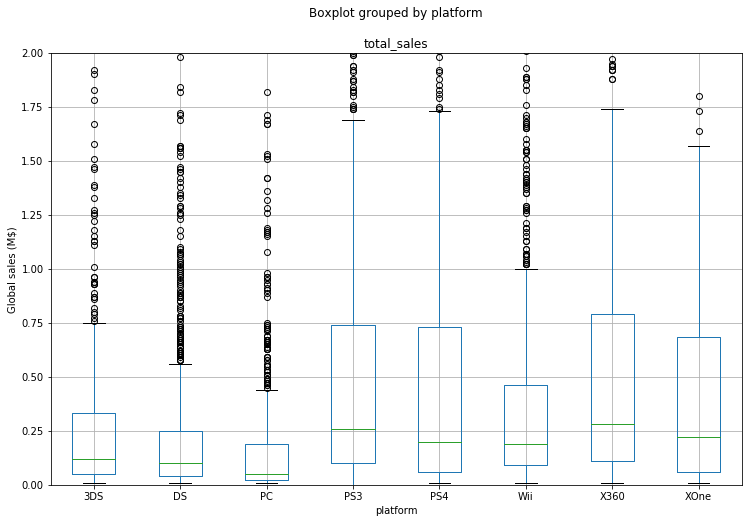

In [59]:
# will choose the top 8 - above 150M$ since 2008 - boxplot of all games global sales 
win_platforms = ['PS4', 'X360', 'PS3', 'Wii', 'DS', '3DS', 'XOne', 'PC']
games_win_platforms = games_since_2008.query('platform in @win_platforms')
fig, ax = plt.subplots(figsize=(12, 8))    
games_win_platforms.boxplot('total_sales', by='platform', ax = ax)
plt.ylabel('Global sales (M$)')
plt.ylim(0, 2)
plt.show()  

The graph shows clearly the leading position of the 5 platforms on the right - both in the median annual sales, and in the Q3 annual sales. 

### Reviews correlation with sales 

Can we find correlation between user and critic reviews on the one hand and sales on the other? for this analysis we will choose **X360** platform - one of the top leading platforms.  

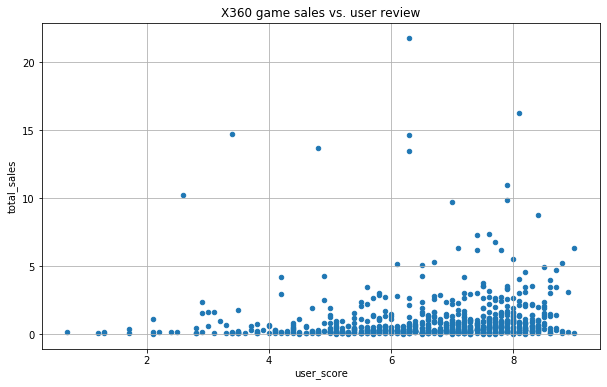

In [60]:
# correlation with user review 
X360 = games_since_2008.query('platform == "X360"')
X360.plot(x='user_score', y='total_sales', kind='scatter', figsize=(10, 6), grid=True)
plt.title('X360 game sales vs. user review')
plt.show()

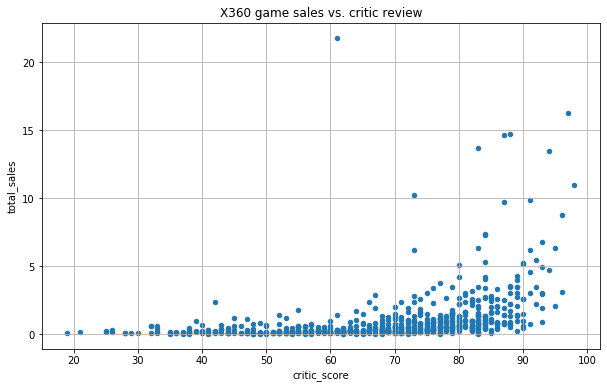

In [61]:
X360.plot(x='critic_score', y='total_sales', kind='scatter', figsize=(10, 6), grid=True)
plt.title('X360 game sales vs. critic review')
plt.show()

While we do see some high sales with high scores - in both graphs we don't really see linear correlation. Let's check the corr numbers (Pearson coefficient):

In [62]:
X360[['total_sales', 'user_score', 'critic_score']].corr()

,total_sales,user_score,critic_score
total_sales,1.000000,0.101101,0.388653
user_score,0.101101,1.000000,0.616848
critic_score,0.388653,0.616848,1.000000


No meaningful linear correlation between score and sales. It is noteworthy that the difference does show that the weak correlation between critic scores and sales (corr 0.39) is almost 4 times bigger than the much weaker correlation between user scores and sales (corr only 0.1 - very weak). The correlation (0.62) between critic and user scores is interesting - but didn't translate to sales.

Will the correlation picture look different when we look at the whole "since 2008" data?  

In [63]:
games_since_2008[['total_sales', 'user_score', 'critic_score']].corr()

,total_sales,user_score,critic_score
total_sales,1.000000,0.084752,0.294131
user_score,0.084752,1.000000,0.569836
critic_score,0.294131,0.569836,1.000000


No, same picture. No linear correlation between reviews and sales. 

### Profitable genres

Which genres are most profitable? 

In [64]:
genre_table = games_since_2008.pivot_table(
    index='genre', values='total_sales', aggfunc=(
        'count', 'sum', 'mean')).sort_values(by='sum', ascending=False)
genre_table

,count,mean,sum
genre,,,
Action,1988,0.475724,945.74
Shooter,583,1.043208,608.19
Sports,958,0.584906,560.34
Role-Playing,783,0.538404,421.57
Misc,994,0.398823,396.43
Racing,403,0.561811,226.41
Platform,244,0.800738,195.38
Simulation,459,0.328497,150.78
Fighting,308,0.482175,148.51


Looking since 2008, clearly 4 genres (Action, Shooter, Sports and Role-Playing) bring most of the sales. The total highest sales come from Action (more than 55% more than the socond one, Shooter), but it's mean sales-per-game is less than half (!) of Shooter, and it's very high sales come also from the biggest number of games (more than 3 times the Shotter number of games).

Again, let's check the changes over time - to see the trends: 

In [65]:
genre_sales_per_year = games_since_2008.pivot_table(
    index='genre', columns='year_of_release', values='total_sales',
    aggfunc='sum').sort_values(by=2016, ascending=False)
genre_sales_per_year

year_of_release,2008,2009,2010,2011,2012,2013,2014,2015,2016
genre,,,,,,,,,
Shooter,59.16,69.29,76.83,98.18,71.75,62.04,65.21,67.51,38.22
Action,134.96,137.69,115.29,116.68,119.25,122.51,97.23,72.02,30.11
Sports,94.58,137.37,91.24,56.08,30.42,41.17,45.15,40.84,23.49
Role-Playing,58.98,47.31,69.65,52.83,46.91,44.45,45.62,37.64,18.18
Fighting,35.02,31.90,14.69,22.41,9.18,7.09,15.85,7.90,4.47
Adventure,24.63,20.23,15.96,15.61,5.79,6.09,5.57,8.16,3.82
Platform,35.13,40.53,31.04,27.68,18.37,24.54,8.81,6.05,3.23
Racing,70.04,33.69,34.37,34.81,13.61,12.37,16.66,8.07,2.79
Misc,86.06,75.81,95.14,54.38,22.22,25.27,23.38,11.57,2.60


We can see that the dominance of the above-mentioned 4 genres is pretty continuous, and **still in place in 2015-2016**. Action lost a lot of it's very prominent leading position (see 2008-2014), and Shooter seems to take the lead in 2015-2016. Let's visualize it in a graph:  

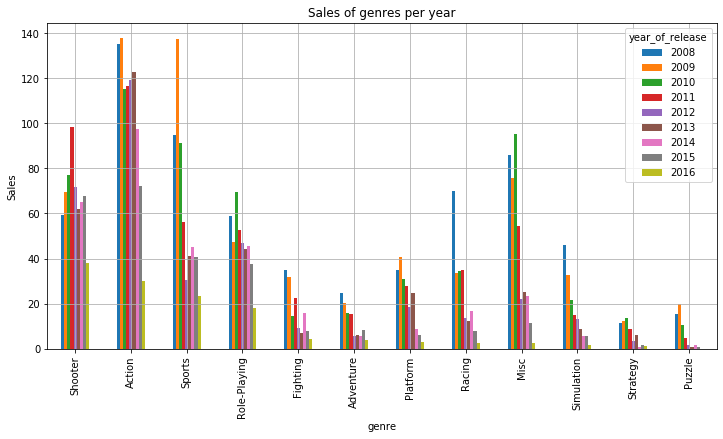

In [66]:
genre_sales_per_year.plot(kind='bar', grid=True, figsize=(12, 6))
plt.title('Sales of genres per year')
plt.ylabel('Sales')
plt.show;

The picture is clear: the 4 leading genres make together the big majority of all games sales. Some genres that were quite popular with pretty high sales in 2008 (e.g. Racing, Simulation) - became almost negligible later. 

## User profile for each region 

To understand the current preferences of users in each region, we will first compare - between the 3 regions - the distribution of each of the following:
1. Platforms market shares
2. Genres market shares
3. ESRB ratings vs. sales (market shares)  

Then we will join the user profile of each region, refering to top platforms, genres and ESRB ratings

**Since we are most interested with the current situation, and since we saw the big changes along time, we will analize this part using 2015-2016 data**. At the end of this section (see 4.7 below) we will also view changes in sales along time - per region. 

### Platforms market share in each region  

In [67]:
# comparing the regions for platforms sales in 2015-2016: 
comp_plat_by_regions_2y = games_with_year.query('year_of_release >= 2015').pivot_table(
    index='platform', values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc='sum').sort_values(
    by='na_sales', ascending=False)
comp_plat_by_regions_2y

,eu_sales,jp_sales,na_sales
platform,,,
PS4,83.54,12.05,63.86
XOne,28.10,0.18,50.30
3DS,7.39,23.55,10.31
WiiU,6.49,4.12,8.86
X360,4.21,0.00,8.05
PS3,7.30,4.97,5.66
PC,9.10,0.00,3.72
PSV,1.08,8.41,0.54
Wii,0.73,0.00,0.49


Some large differences are clear: Of the top selling platforms, EU is leading the sales of PS4 (83.54 M USD, in NA 63.8 M USD), and JP is leading the sales of 3DS (23.55 M USD, vs. only 10.31 in NA and 7.39 in EU). For XOne NA leadership is very clear (50.3 M USD, vs. only 28.1 in EU and 0.18 in JP). 

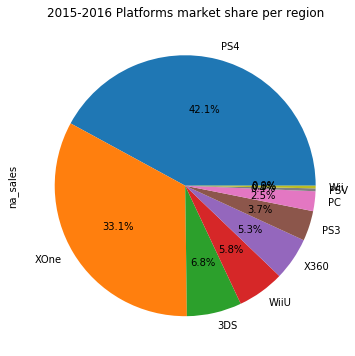

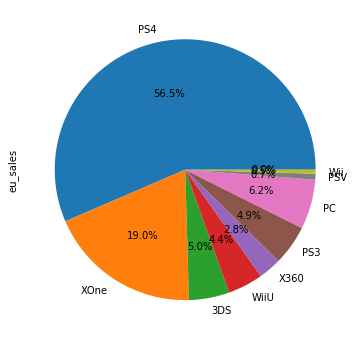

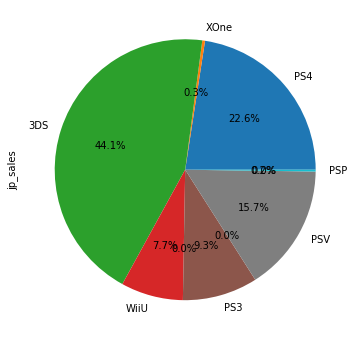

In [68]:
# pies charts to see platforms market shares in each region: 
regions = ['na_sales', 'eu_sales', 'jp_sales']
plt.title('2015-2016 Platforms market share per region')
for r in regions:
    comp_plat_by_regions_2y[r].plot(kind='pie', autopct='%1.1f%%', figsize=(10, 6))
    plt.show()  

In both NA and EU - PS4 and XOne provide together 3/4 of all sales (with EU having over a half(!) of all sales coming from PS4). The remaining 1/4 of the market both in NA and in EU - is divided mainly between 5 other platforms, though not in the same order. 

JP shows different users preferences: 3DS has almost half of the market, and most of the rest is divided between only 4 more platforms, of which PSV (15.7%, third in JP) has only very minor share in both NA and EU.   

Top 5 platforms per region:

**NA**: PS4, XOne, 3DS, WiiU, X360. 

**EU**: PS4, XOne, PC, 3DS, PS3.

**JP**: 3DS, PS4, PSV, PS3, WiiU.

### Genres market share in each region 

In [69]:
# comparing the regions for genres sales in 2015-2016: 
comp_genres_by_regions_2y = games_with_year.query('year_of_release >= 2015').pivot_table(
    index='genre', values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc='sum').sort_values(
    by='na_sales', ascending=False)
comp_genres_by_regions_2y

,eu_sales,jp_sales,na_sales
genre,,,
Shooter,40.28,3.79,48.18
Action,34.82,23.05,33.68
Sports,27.82,1.65,26.31
Role-Playing,17.21,13.41,19.82
Misc,4.26,3.19,5.58
Fighting,3.72,1.54,5.54
Adventure,4.67,2.22,3.84
Platform,3.20,1.42,3.78
Racing,6.52,0.29,2.82


NA is leading Shooter sales (48.18 M USD) with EU close (40.28) but JP far behind (only 3.79), while in Action JP is much more dominant (23.05 vs. 34.82 in EU and 33.68 in NA). Sports is also mainly divided between EU (27.82) and NA (26.31) with only 1.65 in JP (where it is not one of the top 4 genres we saw so dominant on the global picture). Role-Playing again sees JP giving a higher part of sales (13.41) relative to NA (19.82) and EU (17.21). 

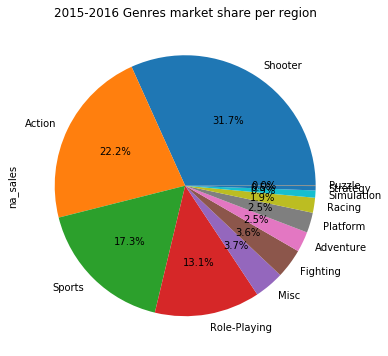

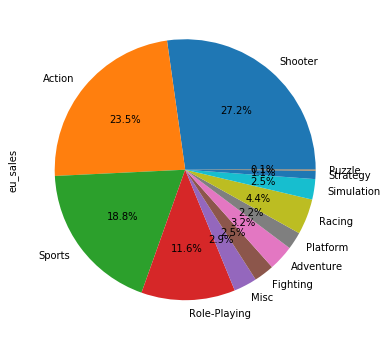

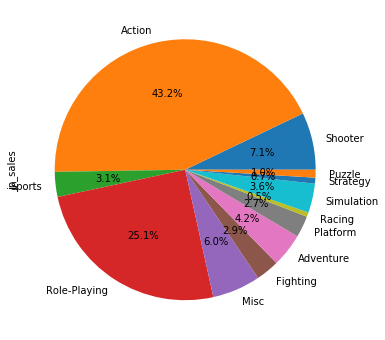

In [70]:
# pies charts to see genres market shares in each region: 
regions = ['na_sales', 'eu_sales', 'jp_sales']
plt.title('2015-2016 Genres market share per region')
for r in regions:
    comp_genres_by_regions_2y[r].plot(kind='pie', autopct='%1.1f%%', figsize=(10, 6))
    plt.show()

In both NA and EU - the 4 global leading genres (Shooter, Action, Sports, Role-Playing) make together more than 80% of the whole market, and in the same order in the two regions. In each region the remainig 20% are mainly divided between 5 genres (not exactly in the same order).  

JP again shows different users preferences: both Action (43.2%) and Role-Playing (25.1%) hold a much bigger market share than they do in NA or EU, and together they make almost 70% of JP games market. Sports is not even in top 5 genres. 

Top 5 Genres per region:

**NA**: Shooter, Action, Sports, Role-Playing, Fighting.  

**EU**: Shooter, Action, Sports, Role-Playing, Racing. 

**JP**: Action, Role-Playing, Shooter, Adventure, Simulation.  

### ESRB ratings vs. sales in each region 

Since we had in 'rating' column quite a few missing values, and in order not to ignore them and get a distorted ESRB ratings market shares - we will first turn them into 'unknown' to see the correct shares in each region. 

In [71]:
# comparing the regions for ESRB ratings sales in 2015-2016:
games_with_year['rating'] = games_with_year['rating'].fillna('unknown')
comp_esrb_by_regions_2y = games_with_year.query('year_of_release >= 2015').pivot_table(
    index='rating', values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc='sum').sort_values(
    by='na_sales', ascending=False)
comp_esrb_by_regions_2y

,eu_sales,jp_sales,na_sales
rating,,,
M,45.54,4.29,47.03
unknown,35.71,32.89,37.44
E,34.83,5.25,26.59
T,20.32,7.70,22.86
E10+,11.54,3.27,17.87


First of all - we see that in all regions, games with missing rating make a large part of all current (2015-2016) sales: in NA and EU they make ~1/4 of all sales, and in JP more than 60%(!) of all sales. Out of the ESRB rated games, in both NA and EU the "Mature" games bring the highest share of sales, then "Everyone", then "Teen" (age 13+), and then E10+ (age 10+). In JP, differently, after the biggest group of missing rating, "Teen" games bring the highest total sales out of the rated games, then "Everyone", only then "Mature", and E10+ here is last as well. Let's visualize it:    

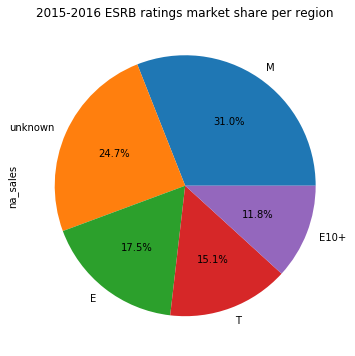

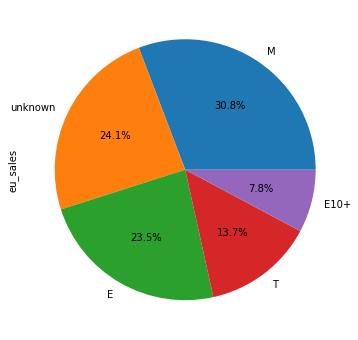

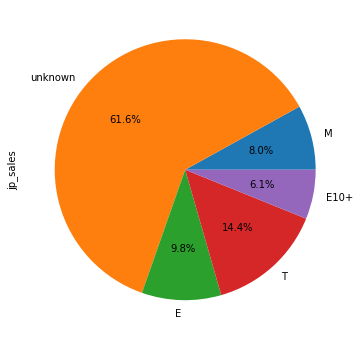

In [72]:
# pies charts to see ESRB ratings market shares in each region: 
regions = ['na_sales', 'eu_sales', 'jp_sales']
plt.title('2015-2016 ESRB ratings market share per region')
for r in regions:
    comp_esrb_by_regions_2y[r].plot(kind='pie', autopct='%1.1f%%', figsize=(10, 6))
    plt.show()

The large part of unknown rating is clear in all, and much more in JP. Out of rated games- The different JP market picture is very clear (strong leadership of "Teen" rating) - and maybe is related to the JP region unique user preferences we saw about platform and genre.  

### NA User profile

Top 5 platforms: 
PS4, XOne, 3DS, WiiU, X360 (first 2 bring 3/4 of all sales).

Top 5 Genres:
Shooter, Action, Sports, Role-Playing, Fighting (first 4 bring more than 80% of all sales). 

ESRB ratings: 
About 1/4 missing rating, "Mature" games bring the highest share of sales (31%), then "Everyone", then "Teen" (age 13+), and then E10+ (age 10+)

### EU User profile

Top 5 platforms: 
PS4, XOne, PC, 3DS, PS3 (first 2 bring 3/4 of all sales, and PS4 alone brings 56.5% of sales).

Top 5 Genres:
Shooter, Action, Sports, Role-Playing, Racing (first 4 bring more than 80% of all sales). 

ESRB ratings: 
About 1/4 missing rating, "Mature" games bring the highest share of sales (~31%), then "Everyone", then "Teen" (age 13+), and then E10+ (age 10+)

### JP User profile

Top 5 platforms: 
3DS, PS4, PSV, PS3, WiiU (3DS alone brings almost half the market).

Top 5 Genres:
Action, Role-Playing, Shooter, Adventure, Simulation (Action (43.2%) and Role-Playing (25.1%) make together almost 70% of JP games market). 

ESRB ratings: 
60%+ of all sales come from games with missing rating. Out of the rated games, "Teen" games bring the highest total sales, then "Everyone", then "Mature", and E10+ is last. 

### Sales changes over the years - per region

As promised above - we will view now the salse changes over the years - per region, to get the idea of the global and regional dynamic. 

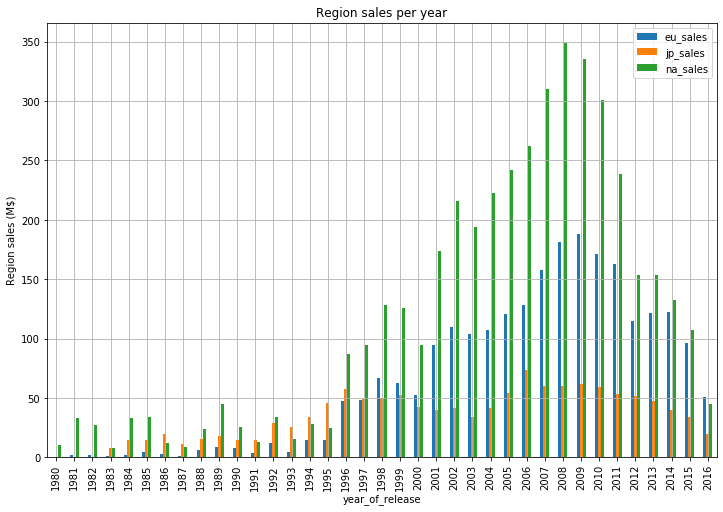

In [73]:
games_with_year.pivot_table(index='year_of_release', values=regions, aggfunc='sum').plot(
    kind='bar', grid=True, figsize=(12, 8))
plt.title('Region sales per year')
plt.ylabel('Region sales (M$)')
plt.show;

While the general global sales per year, and it's trends, was already discussed above (see 3.2) - some points are noteworthy in this analysis:

NA had clear leadership of the sales, but from 2012 and on it's advantage is much lower than before, and in 2015-2016 it might have even been lost to EU (2016 data may be incomplete). 
JP part of the global sales was much smaller, and is much larger since the 2012 change (and growing since).      

## Testing statistical hypotheses

### Average user ratings of the Xbox One and PC platforms are the same

We will use a test for hypothesis on the equality of two independant population means.

Our null hypothesis to test will be:

**The average user rating of the Xbox One and PC platforms are equal**

The alternative hypothesis is:

The average user rating of the Xbox One and PC platforms are not equal

first we will check th mean and variance of the user_score between the two platforms:

In [74]:
# Compare the mean and the variance of the user_score between the 2 platforms:
x1pc_data = games.query('platform == "XOne" or platform == "PC"')
comp_plat_scores_stats = x1pc_data.pivot_table(index='platform', values='user_score', aggfunc=['mean', 'var'])
comp_plat_scores_stats

,mean,var
,user_score,user_score
platform,,
PC,7.062468,2.340787
XOne,6.521429,1.906997


We can see the mean user rating of PC (7.06) is ~8% higher than that of XOne (6.52). The question is wether this difference can be random - and for this we will run the statistical test.
Since the variance is close enough - we will keep 'equal_var' in the statistical test on it's default True value. We will set significance level on 0.05, as common, since there is no special reason to set a different level. Unlike the mean and var methods, the statistical test can't include null values - so we will drop them before the test.  

In [75]:
# Test the hypothesis about mean equality:
games1 = games.dropna()
xone = games1.query('platform == "XOne"')['user_score'] 
pc = games1.query('platform == "PC"')['user_score']

alpha = 0.05

results = st.ttest_ind(
    xone,
    pc)
print('p-value: ', results.pvalue)

if (results.pvalue < alpha):
    print(
        "We reject the null hypothesis"
    )
else:
    print(
        "We can't reject the null hypothesis"
    )

p-value:  2.4909638124872165e-05
We reject the null hypothesis


We can see that the p-value is very small, and smaller than our set significance level alpha, which means that
our statistical test shows that the probabillity that the difference between the means is random - is very low, therefore **we reject the hypothsis that the means are equal.**  

### Average user ratings for the Action and Sports genres are different

Again, we will use a test for hypothesis on the equality of two independant population means.

Our null hypothesis to test will be:

**The average user rating of the Action and Sports genres are equal**

The alternative hypothesis is:

The average user rating of the Action and Sports genres are not equal

first we will check th mean and variance of the user_score between the two genres:

In [76]:
# Compare the mean and the variance of the user_score between the 2 genres:
ac_sp_data = games.query('genre == "Action" or genre == "Sports"')
comp_genre_scores_stats = ac_sp_data.pivot_table(index='genre', values='user_score', aggfunc=['mean', 'var'])
comp_genre_scores_stats

,mean,var
,user_score,user_score
genre,,
Action,7.054044,2.031747
Sports,6.961197,2.596515


We can see the mean user rating of Action (7.05) is only ~1% higher than that of Sports (6.96). The question is wether this tiny difference can be random - and for this we will run the statistical test.
Since the variance is close enough - we will again keep 'equal_var' in the statistical test on it's default True value. Again we will set significance level on 0.05, as common, since there is no special reason to set a different level. Again we will use here the data without the null values.

In [77]:
# Test the hypothesis about mean equality:
action = games1.query('genre == "Action"')['user_score'] 
sports = games1.query('genre == "Sports"')['user_score']

alpha = 0.05

results = st.ttest_ind(
    action,
    sports)
print('p-value: ', results.pvalue)

if (results.pvalue < alpha):
    print(
        "We reject the null hypothesis"
    )
else:
    print(
        "We can't reject the null hypothesis"
    )

p-value:  0.7959786214567501
We can't reject the null hypothesis


Not surprisingly, we can see that the p-value is higher than our set significance level alpha, which means that
our statistical test shows that the probabillity that the tiny difference between the means is random - is quite high - therefore **we can't reject the hypothsis that the means are equal.**  

## General conclusion

1. **Project goal**: to identify patterns that determine success in sales, in order to identify potential big winners   

2. Initial data included 16715 entries from 1980 to 2016 (2016 data may be incomplete).

3. **Preparing data**: 2 entries with missing game name (and genre) were dropped. Other missing values were sliced-out when needed but without dropping more data from the general dataset, due to it's value. Total(global) sales column was calculated and added. few data types were converted, and column names were changed to lower case. 

4. **Number of games released every year**: a very dynamic picture: the 80' are almost all below 22 games released each year (with two local peaks that dont continue, in '81-'82). The 90' have a gradual rise, with a peak of 379 in '98 and solid ~350 at the end of the dacade. The 2000' first dacade had a gradual steep jump to a peak of 1400+ in 2008-2009. Then comes a teep decline to 653 games released in 2012, and since then numbers remain in the ~550-650 area (the 502 games in 2016 may be incomplete data). 

5. **Global sales along the years**: Global sales in milion USD show generally a similar dynamic to the one that was obderved in the number of games released each year. Dramatic **peak** in 2008-2009 (above 650M USD a year), then steep **decline** to 2012 (~350M USD), another decline 2013-2015 (2015 - ~270M USD), and 2016 may be misleading because of incomplete data. For 2016 situation - the trend seems to be less sales every year. 

6. **Winning platforms**: Some platforms used to be very popular but now have zero sales (e.g. DS, PS, PS2). When we watch the timeline for these platforms - it seems it is around 10 years between when they appear and when they fade (e.g. PS2: 2000-2011). Both top **current leaders** (PS4 and XOne) only appeared in 2013. PS4 leads constantly since 2014, and both are with growth untill 2015, much more dramatic in 2014 and much less in 2015 (2016 data may be incomplete). 3DS grew untill 2013, and since then is declining. **These three platforms make together the big majority of 2015-1016 sales**, all the rest showing much lower numbers in the last two years. Steep decline is seen for PS3 (replaced by PS4) and X360 (replaced by XOne) - both were the top leader platforms in 2012. Wii lost almost all it's sales during these years, and currently even WiiU (it's replacement) is on a decline trend. Following this dynamic picture - Our user profiles for each region (see below) are based on the most reliable current data (2015-2016, since 2016 data may be incomplete). 

7. **Reviews correlation with sales**: checked for X360 platform: No meaningful linear correlation between score and sales. It is noteworthy that the weak correlation between critic scores and sales (corr 0.39) is almost 4 times bigger than the much weaker correlation between user scores and sales (corr only 0.1 - very weak). The correlation (0.62) between critic and user scores is interesting - but didn't translate to sales. When checked for a much larger data (all platforms since 2008) - still no linear correlation between scores (user or critic) and sales. 

8. **Profitable genres**: Looking since 2008, 4 genres (Action, Shooter, Sports and Role-Playing) bring most of the sales. The total highest sales come from Action (more than 55% more than the socond one, Shooter), but it's mean sales-per-game is less than half (!) of Shooter, and it's very high sales come also from the biggest number of games (more than 3 times the Shotter number of games). On the time-line, the dominance of the above-mentioned 4 genres is pretty continuous, and still in place in 2015-2016. Action lost a lot of it's very prominent leading position (especially in 2008-2014), and Shooter seems to take the lead in 2015-2016. the 4 leading genres make together the big majority of all games sales. Some genres that were quite popular with pretty high sales in 2008 (e.g. Racing, Simulation) - became almost negligible later. 


9. **NA user profile**:
- Top 5 platforms: PS4, XOne, 3DS, WiiU, X360 (first 2 bring 3/4 of all sales).

- Top 5 Genres: Shooter, Action, Sports, Role-Playing, Fighting (first 4 bring more than 80% of all sales). 

- ESRB ratings: About 1/4 missing rating, "Mature" games bring the highest share of sales (31%), then "Everyone", then "Teen" (age 13+), and then E10+ (age 10+)

10. **EU user profile**: 
- Top 5 platforms: PS4, XOne, PC, 3DS, PS3 (first 2 bring 3/4 of all sales, and PS4 alone brings 56.5% of sales).

- Top 5 Genres: Shooter, Action, Sports, Role-Playing, Racing (first 4 bring more than 80% of all sales). 

- ESRB ratings: About 1/4 missing rating, "Mature" games bring the highest share of sales (~31%), then "Everyone", then "Teen" (age 13+), and then E10+ (age 10+)

11. **JP user profile**:
- Top 5 platforms: 3DS, PS4, PSV, PS3, WiiU (3DS alone brings almost half the market).

- Top 5 Genres: Action, Role-Playing, Shooter, Adventure, Simulation (Action (43.2%) and Role-Playing (25.1%) make together almost 70% of JP games market). 

- ESRB ratings: 60%+ of all sales come from games with missing rating. Out of the rated games, "Teen" games bring the highest total sales, then "Everyone", then "Mature", and E10+ is last. 

12. **Sales changes over the years - per region**: NA had clear leadership of the sales, but from 2012 and on it's advantage is much lower than before, and in 2015-2016 it might have even been lost to EU (2016 data may be incomplete). JP part of the global sales was much smaller, and is much larger since the 2012 change (and growing since).

13. **Testing statistical hypothesis 1**: Average user ratings of the Xbox One and PC platforms are the same.
- Our null hypothesis to test was: The average user rating of the Xbox One and PC platforms are equal. the mean user rating of PC (7.06) is ~8% higher than that of XOne (6.52). Our statistical test showed that the probabillity that the difference between the means is random - is very low (and way smaller than our alpha), therefore we reject the hypothsis that the means are equal. 

14. **Testing statistical hypothesis 2**: Average user ratings for the Action and Sports genres are different. 
- Our null hypothesis to test was: The average user rating of the Action and Sports genres are equal. the mean user rating of Action (7.05) is only ~1% higher than that of Sports (6.96). Our statistical test showed that the probabillity that the tiny difference between the means is random - is quite high (and higher than our alpha) - therefore we can't reject the hypothsis that the means are equal.

15. **Overall conclusion**: Actual Period's Sales success patterns, and the potential big winners by platform, genre and ESRB, were identified per region - and planning (campaigns etc.) should take these into account (but ESRB much less, due to large share of missing rating). There should be equal focus on NA and EU, and also focus on JP due to it's growing share of the global sales. 